In [ ]:
import torch
torch.set_printoptions(sci_mode=False)  #Removes printing in scientific notation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
!wget "www.cs.umn.edu/~sjguy/data/WhiteWine.txt"

--2023-10-27 22:00:51--  http://www.cs.umn.edu/~sjguy/data/WhiteWine.txt
Resolving www.cs.umn.edu (www.cs.umn.edu)... 104.18.20.107, 104.18.21.107, 2606:4700::6812:146b, ...
Connecting to www.cs.umn.edu (www.cs.umn.edu)|104.18.20.107|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.umn.edu/~sjguy/data/WhiteWine.txt [following]
--2023-10-27 22:00:51--  https://www.cs.umn.edu/~sjguy/data/WhiteWine.txt
Connecting to www.cs.umn.edu (www.cs.umn.edu)|104.18.20.107|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www-users.cs.umn.edu/~sjguy/data/WhiteWine.txt [following]
--2023-10-27 22:00:51--  http://www-users.cs.umn.edu/~sjguy/data/WhiteWine.txt
Resolving www-users.cs.umn.edu (www-users.cs.umn.edu)... 134.84.66.195
Connecting to www-users.cs.umn.edu (www-users.cs.umn.edu)|134.84.66.195|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www-

In [ ]:
df = pd.read_csv('WhiteWine.txt')

Text(0.5, 1.0, 'Histogram of Quality Ratings')

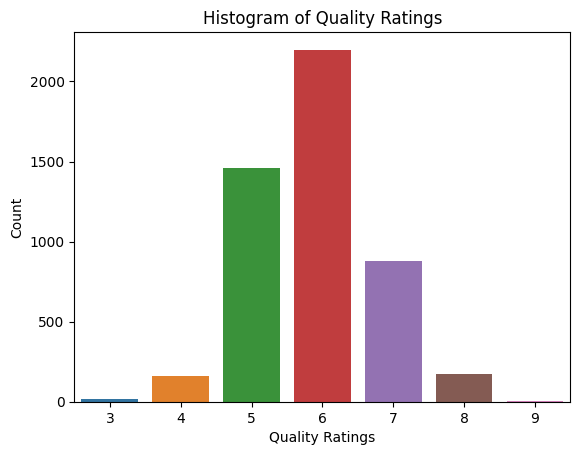

In [ ]:
sns.countplot(data=df, x='quality')

plt.xlabel('Quality Ratings')
plt.ylabel('Count')
plt.title('Histogram of Quality Ratings')

This data follows a normal distribution. The most common rating is 6, and low qualities and higher qualities are rarer. I imagine the reason for this distribution is because they wanted to score wine with only a small subset being the best, a small subset being the worst, and most falling into the average score. Following a normal distribution allows us to keep the assumption that our predictor will be linear.

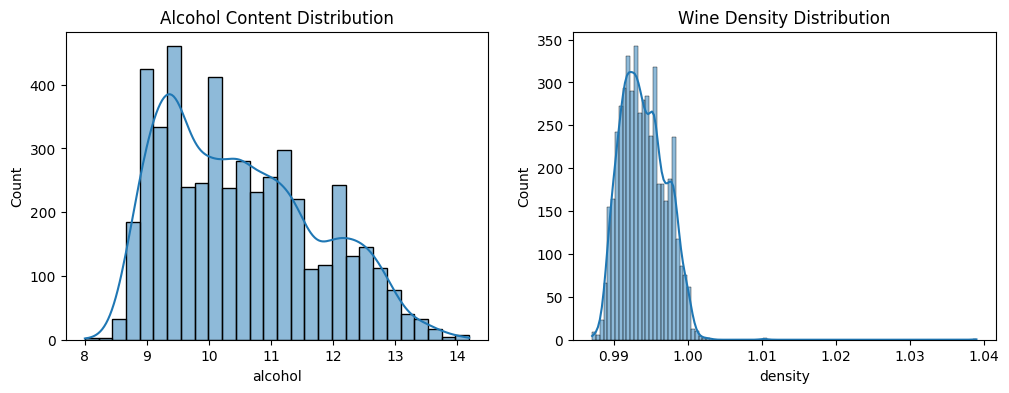

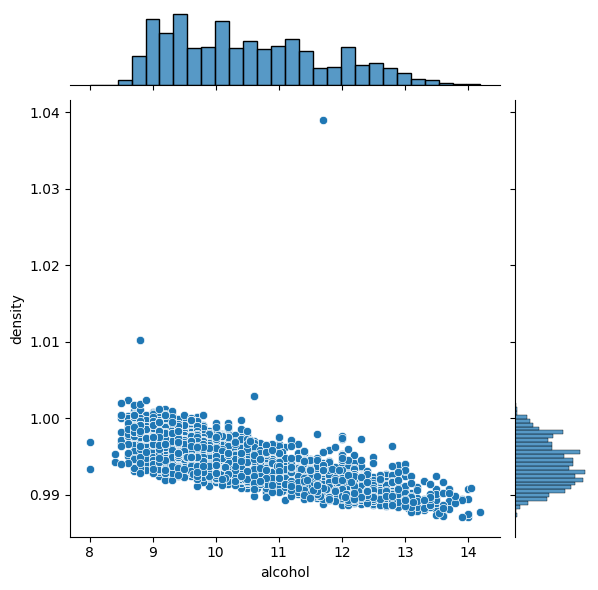

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data=df, x='alcohol', kde=True, ax=axes[0])
axes[0].set_title('Alcohol Content Distribution')

sns.histplot(data=df, x='density', kde=True, ax=axes[1])
axes[1].set_title('Wine Density Distribution')
plt.show()

sns.jointplot(data=df, x='alcohol', y='density', kind='scatter', height=6)
plt.show()

These plots show that density and alcohol content are highly negatively correlated. This might be because alcohol is less dense than water.

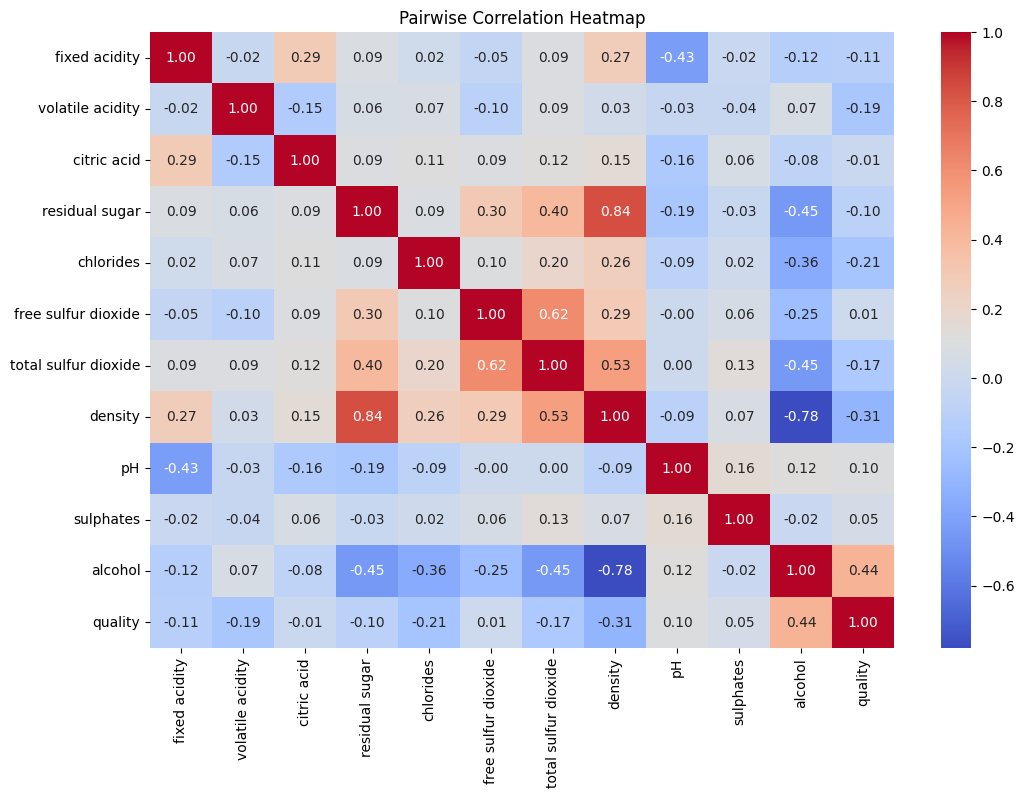

In [ ]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pairwise Correlation Heatmap')
plt.show()

Some highly correlated features include, alcohol content & density, density & residual sugar, etc. It seems that alcohol content and residual sugar are correleated with many features.

In [ ]:
# PROBLEM 2

For choosing inputs, I went in order of highest correlation with quality. So for linear, I chose alcohol content, and for multi & multi w/ interaction I chose alcohol content, density, and chlorides. I chose to normalize the data because as we saw in lecture, unnormalized data can lead to issues when calculating the gradient descent and loss function.

In [ ]:
# Linear model
x = torch.Tensor(df['alcohol'].values)
y = torch.Tensor(df["quality"].values)

In [ ]:
#normalize vectors:
x_mean = x.mean(dim=0)
x_norm = (x-x_mean)/x_mean
y_mean = y.mean(dim=0)
y_norm = (y-y_mean)/y_mean

In [ ]:
def gradDec(model, n_params, x, y, lr=0.01, n_epochs=2000, print_rate=200):

  params = 0.1*torch.rand(n_params).float() #Random inital paramaters
  params.requires_grad = True

  for epoch in range(n_epochs):
    y_pred = model(params, x)
    loss_tenor = (y_pred - y)**2
    loss = loss_tenor.mean()
    loss.backward()
    with torch.no_grad():
      params -= lr*params.grad
      params.grad.zero_()
    if epoch%print_rate==0:
      print("epoch:",epoch,"loss=",loss.item())

  return params

In [ ]:
def linearModel(params, inputs):
  y_pred = params[0]*inputs + params[1]
  return y_pred

In [ ]:
linear_tens = gradDec(linearModel,2,x_norm,y_norm)

epoch: 0 loss= 0.022159656509757042
epoch: 200 loss= 0.021636690944433212
epoch: 400 loss= 0.02129979059100151
epoch: 600 loss= 0.020997898653149605
epoch: 800 loss= 0.02072734385728836
epoch: 1000 loss= 0.020484868437051773
epoch: 1200 loss= 0.020267562940716743
epoch: 1400 loss= 0.02007281221449375
epoch: 1600 loss= 0.019898274913430214
epoch: 1800 loss= 0.019741851836442947


In [ ]:
linear_predictions = linearModel(linear_tens, x_norm)


In [ ]:
# multi-linear model
def multiLinearModel(params, inputs):
  y_pred = params[0]*inputs[:,0] + params[1]*inputs[:,1] + params[2]*inputs[:,2] + params[3]
  return y_pred

In [ ]:
features = ['alcohol', 'density','chlorides']
x = torch.Tensor(df[features].values)
y = torch.Tensor(df["quality"].values)

In [ ]:
#normalize vectors:
x_mean = x.mean(dim=0)
x_norm = (x-x_mean)/x_mean
y_mean = y.mean(dim=0)
y_norm = (y-y_mean)/y_mean

In [ ]:
multi_tens = gradDec(multiLinearModel,4,x_norm,y_norm,0.001)

epoch: 0 loss= 0.0279699619859457
epoch: 200 loss= 0.026026181876659393
epoch: 400 loss= 0.024770036339759827
epoch: 600 loss= 0.02388526313006878
epoch: 800 loss= 0.023219365626573563
epoch: 1000 loss= 0.0226951465010643
epoch: 1200 loss= 0.022270675748586655
epoch: 1400 loss= 0.021921072155237198
epoch: 1600 loss= 0.02163013257086277
epoch: 1800 loss= 0.021386394277215004


In [ ]:
multi_pred = multiLinearModel(multi_tens, x_norm)

In [ ]:
def multiLinearModel_withInteraction(params, inputs):
  y_pred = params[0]*inputs[:,0] + params[1]*inputs[:,1] + params[2]*(inputs[:,0]*inputs[:,1]) + params[3]
  return y_pred

In [ ]:
inter_tens = gradDec(multiLinearModel_withInteraction,4,x_norm,y_norm,0.005,2000)

epoch: 0 loss= 0.022053323686122894
epoch: 200 loss= 0.021825827658176422
epoch: 400 loss= 0.021642105653882027
epoch: 600 loss= 0.02146875113248825
epoch: 800 loss= 0.021304652094841003
epoch: 1000 loss= 0.021149305626749992
epoch: 1200 loss= 0.02100224234163761
epoch: 1400 loss= 0.020863022655248642
epoch: 1600 loss= 0.020731229335069656
epoch: 1800 loss= 0.02060646563768387


In [ ]:
inter_pred = multiLinearModel_withInteraction(inter_tens, x_norm)

In [ ]:
# Formula for calculating unnormalized quality:
# y = b + m1*x1 + m2*x2 + ... + mn*xn + e

In [ ]:
# Problem 3

In [ ]:
def threshold_accuracy(actual_ratings, predicted_ratings, threshold):
    correct_predictions = 0
    total_predictions = len(actual_ratings)

    for actual, predicted in zip(actual_ratings, predicted_ratings):
        if abs(actual - predicted) <= threshold:
            correct_predictions += 1

    accuracy = correct_predictions/total_predictions
    return accuracy


In [ ]:
def print_threshold(pred):
    print('model at threshold 0.25:', threshold_accuracy(y_norm, pred, 0.25))
    print('model at threshold 0.5:', threshold_accuracy(y_norm, pred, 0.5))
    print('model at threshold 1:', threshold_accuracy(y_norm, pred, 1))

In [ ]:
print('LINEAR')
print_threshold(linear_predictions)
print('MULTILINEAR')
print_threshold(multi_pred)
print('MULTILINEAR W/ INTERACTION')
print_threshold(inter_pred)

LINEAR
model at threshold 0.25: 0.92588811759902
model at threshold 0.5: 0.9981625153123724
model at threshold 1: 1.0
MULTILINEAR
model at threshold 0.25: 0.92588811759902
model at threshold 0.5: 0.9979583503470805
model at threshold 1: 1.0
MULTILINEAR W/ INTERACTION
model at threshold 0.25: 0.92588811759902
model at threshold 0.5: 0.9987750102082482
model at threshold 1: 1.0


All models performed very similarly, but multilinear w/ interaction performed the best when looking at the 0.5 threshold. Overall, the results were identical other than the 0.5 threshold score.

In [ ]:
def cross_validate():
  linear_accuracy = []
  multi_accuracy = []
  inter_accuracy = []

  x = torch.Tensor(df['alcohol'].values)
  y = torch.Tensor(df["quality"].values)
  x_mean = x.mean(dim=0)
  x_norm = (x-x_mean)/x_mean
  y_mean = y.mean(dim=0)
  y_norm = (y-y_mean)/y_mean
  for i in range(10):
    linear_tens = gradDec(linearModel,2,x_norm,y_norm)
    linear_predictions = linearModel(linear_tens, x_norm)
    linear_accuracy.append([threshold_accuracy(y_norm,linear_predictions,0.25),threshold_accuracy(y_norm,linear_predictions,0.5),threshold_accuracy(y_norm,linear_predictions,1)])
  features = ['alcohol', 'density','chlorides']
  x = torch.Tensor(df[features].values)
  y = torch.Tensor(df["quality"].values)

  x_mean = x.mean(dim=0)
  x_norm = (x-x_mean)/x_mean
  y_mean = y.mean(dim=0)
  y_norm = (y-y_mean)/y_mean
  for i in range(10):
    multi_tens = gradDec(multiLinearModel,4,x_norm,y_norm,0.001)
    multi_pred = multiLinearModel(multi_tens, x_norm)
    multi_accuracy.append([threshold_accuracy(y_norm,multi_pred,0.25),threshold_accuracy(y_norm,multi_pred,0.5),threshold_accuracy(y_norm,multi_pred,1)])

    inter_tens = gradDec(multiLinearModel_withInteraction,4,x_norm,y_norm,0.005,2000)
    inter_pred = multiLinearModel_withInteraction(inter_tens, x_norm)
    inter_accuracy.append([threshold_accuracy(y_norm,inter_pred,0.25),threshold_accuracy(y_norm,inter_pred,0.5),threshold_accuracy(y_norm,inter_pred,1)])
  np.array(linear_accuracy)
  np.array(multi_accuracy)
  np.array(inter_accuracy)
  linear_means = np.mean(linear_accuracy, axis=0)
  multi_means = np.mean(multi_accuracy, axis=0)
  inter_means = np.mean(inter_accuracy, axis=0)
  return linear_means, multi_means, inter_means




In [ ]:
linear_means, multi_means, inter_means = cross_validate()

In [ ]:
print(linear_means)
print(multi_means)
print(inter_means)

[0.92588812 0.99816252 1.        ]
[0.92594937 0.99842793 1.        ]
[0.92588812 0.99875459 1.        ]


Overall, these results were very similar to the one initial run. After 10 runs averaged, the multilinear had the highest accuracy at t=0.25, and multilinear w/ interaction had the highest accuracy at t=0.5